In [2]:
import os
import glob
import segyio
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder

In [3]:
def instantaneous_frequency(seismic_data, sample_rate=4):
    # Compute the analytic signal using Hilbert Transform
    analytic_signal = hilbert(seismic_data)
    
    # Compute the instantaneous phase (angle of analytic signal)
    instantaneous_phase = np.angle(analytic_signal)
    
 
    # compute the derivative and multiply by the sample rate (in Hz)
    phase_derivative = np.diff(instantaneous_phase)  # First derivative of phase
    fs = 1000 / sample_rate  # Convert sample rate to Hz (1/sample_rate in seconds)
    instantaneous_freq = np.abs(phase_derivative) * fs / (2 * np.pi)  # Frequency in Hz
    
    return instantaneous_freq

In [4]:
# Path to SEG-Y file
path = 'C://Users/sushila/Desktop/Data_shared_with Participants/Data/2D Seismic/Unkown-1/LO-6-86_01._KNGD export.sgy'

# Open SEG-Y file and process all traces
with segyio.open(path, "r", strict=False) as f:
    f.mmap()  # Memory map the file for efficient access
    
    # Get the number of traces
    num_traces = len(f.trace)
    print(f"Number of traces: {num_traces}")

    # Dictionary to store DataFrames for each trace
    dataframes = {}

    # Loop through each trace and process them individually
    for trace_index in range(num_traces):
        trace_data = f.trace[trace_index]  # Get the trace data
        
        # Retrieve sampling interval (in ms) and calculate time axis
        dt = segyio.dt(f) / 1000  # Convert to milliseconds (time in ms)
        time_axis = np.arange(len(trace_data)) * dt
        time_axis = time_axis / 1000
        
        # Create DataFrame for the trace
        df_trace = pd.DataFrame({
            "Time (s)": time_axis,  # Time in milliseconds
            "Amplitude": trace_data
        })
        
        # Calculate instantaneous frequency
        instantaneous_freq = instantaneous_frequency(trace_data, sample_rate=4) 

        # Add NaN to the start to align the length
        instantaneous_freq_full = np.concatenate(([np.nan], instantaneous_freq))
        df_trace['Instantaneous_freq'] = instantaneous_freq_full
        # Feature engineering for resampled data
        df_trace['Amplitude_abs'] = df_trace['Amplitude'].abs()
        df_trace['Amplitude_roll_mean'] = df_trace['Amplitude'].rolling(window=5, min_periods=1).mean()
        df_trace['Amplitude_energy'] = df_trace['Amplitude'] ** 2
        

        # Find the first non-zero amplitude index
        first_non_zero_index = df_trace[df_trace['Amplitude'] != 0].index[0]

        # Slice the DataFrame from the first non-zero index onward
        df_filtered = df_trace.iloc[first_non_zero_index:]

        # Store the processed DataFrame in the dictionary
        dataframes[f"dataframe_{trace_index}"] = df_filtered

# Example: Accessing DataFrame for trace 5
df_trace_5 = dataframes["dataframe_5"]
df_trace_5


Number of traces: 744


,Time (s),Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy
84,0.336,-548.169922,11.029096,548.169922,-109.633984,3.004902e+05
85,0.340,-2521.579102,26.351789,2521.579102,-613.949805,6.358361e+06
86,0.344,-3617.917969,223.038330,3617.917969,-1337.533398,1.308933e+07
87,0.348,-2960.114258,24.417917,2960.114258,-1929.556250,8.762276e+06
88,0.352,-986.705078,24.962715,986.705078,-2126.897266,9.735869e+05
...,...,...,...,...,...,...
1121,4.484,-4385.351562,32.045528,4385.351562,986.704883,1.923131e+07
1122,4.488,-2083.043945,220.196701,2083.043945,-1074.411719,4.339072e+06
1123,4.492,328.901367,42.375027,328.901367,-2017.262695,1.081761e+05
1124,4.496,328.901367,103.980827,328.901367,-1951.482422,1.081761e+05


In [5]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*TEMP.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_TEMP')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
data_unknown1 = combined_data[combined_data['holeid'].isin(['LONCCARICA_1' ])]

X = data_unknown1[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy']]


# Target variable is 'PHI'
y = data_unknown1['TEMP']


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best1 = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred1=RF_best1.predict(X_test)

rmse = np.sqrt(np.mean((y_pred1 - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.2503


In [6]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*TEMP.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_TEMP')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
data_unknown1 = combined_data[combined_data['holeid'].isin(['VIROVITICA_1' ])]

X = data_unknown1[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy']]


# Target variable is 'PHI'
y = data_unknown1['TEMP']


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best2 = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred2=RF_best2.predict(X_test)

rmse = np.sqrt(np.mean((y_pred2- y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.8680


In [7]:
all_predictions

NameError: name 'all_predictions' is not defined

In [8]:
import segyio
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Initialize the empty DataFrame to store all predictions
all_predictions = pd.DataFrame(columns=['Trace_Index', 'Time (s)', 'TEMP'])

# Path to SEG-Y file
path = 'C://Users/sushila/Desktop/Data_shared_with Participants/Data/2D Seismic/Unkown-1/LO-6-86_01._KNGD export.sgy'

# Open SEG-Y file and process all traces
with segyio.open(path, "r", strict=False) as f:
    f.mmap()  # Memory map the file for efficient access
    
    # Get the number of traces
    num_traces = len(f.trace)
    print(f"Number of traces: {num_traces}")

    # Loop through each trace and process them individually
    for trace_index in range(num_traces):
        trace_data = f.trace[trace_index]  # Get the trace data
        
        # Retrieve sampling interval (in ms) and calculate time axis
        dt = segyio.dt(f) / 1000  # Convert to milliseconds (time in ms)
        time_axis = np.arange(len(trace_data)) * dt  # Time axis for the trace (in ms)
        time_axis = time_axis / 1000

        # Create DataFrame for the trace
        df_trace = pd.DataFrame({
            "Time (s)": time_axis,  # Time in milliseconds
            "Amplitude": trace_data
        })
        
        # Calculate instantaneous frequency
        instantaneous_freq = instantaneous_frequency(trace_data, sample_rate=4) 

        # Add NaN to the start to align the length
        instantaneous_freq_full = np.concatenate(([np.nan], instantaneous_freq))
        df_trace['Instantaneous_freq'] = instantaneous_freq_full
        # Feature engineering for resampled data
        df_trace['Amplitude_abs'] = df_trace['Amplitude'].abs()
        df_trace['Amplitude_roll_mean'] = df_trace['Amplitude'].rolling(window=5, min_periods=1).mean()
        df_trace['Amplitude_energy'] = df_trace['Amplitude'] ** 2
        # Resample and feature engineering 
        df_resampled = df_trace  # Simplified for clarity
        # Drop rows with NaN values in the features
        df_resampled_clean = df_resampled.dropna(subset=['Time (s)', 'Amplitude', 'Instantaneous_freq', 'Amplitude_abs', 'Amplitude_roll_mean', 'Amplitude_energy']).copy()
        X_scaled = scaler.transform(df_resampled_clean)
        y_pred_trace1 = RF_best1.predict(X_scaled)
        y_pred_trace2 = RF_best2.predict(X_scaled)
        y_pred_trace = (y_pred_trace1 + y_pred_trace2)/2
        
        # Store predicted TEMP in the DataFrame
        df_resampled_clean['TEMP'] = y_pred_trace
        
        # Filter based on a time condition (e.g., <= 1.2 seconds)
        df_resampled_clean = df_resampled_clean[df_resampled_clean['Time (s)'] <= 1.2].copy()

        # Check if the DataFrame is empty after filtering
        if df_resampled_clean.empty:
            print(f"Trace {trace_index}: No data after filtering. Skipping.")
            continue

        # Create a new time range with step size of 0.001 seconds for resampling
        new_time = np.arange(
            df_resampled_clean['Time (s)'].min(),
            df_resampled_clean['Time (s)'].max(),
            0.001
        )

        # Interpolate TEMP values to match the new time range
        new_temp = np.interp(new_time, df_resampled_clean['Time (s)'], df_resampled_clean['TEMP'])

        # Append predictions to the master DataFrame
        temp_df = pd.DataFrame({
            'Trace_Index': trace_index,
            'Time (s)': new_time,
            'TEMP': new_temp
        })
        all_predictions = pd.concat([all_predictions, temp_df], ignore_index=True)


# Save all predictions to a CSV file
all_predictions.to_csv("all_predictions.csv", index=False)
print("All predictions saved to all_predictions.csv")


Number of traces: 744
All predictions saved to all_predictions.csv


In [9]:
all_predictions

,Trace_Index,Time (s),TEMP
0,0,0.004,60.817685
1,0,0.005,60.817685
2,0,0.006,60.817685
3,0,0.007,60.817685
4,0,0.008,60.817685
...,...,...,...
889819,743,1.195,108.532331
889820,743,1.196,108.683307
889821,743,1.197,108.691117
889822,743,1.198,108.698927


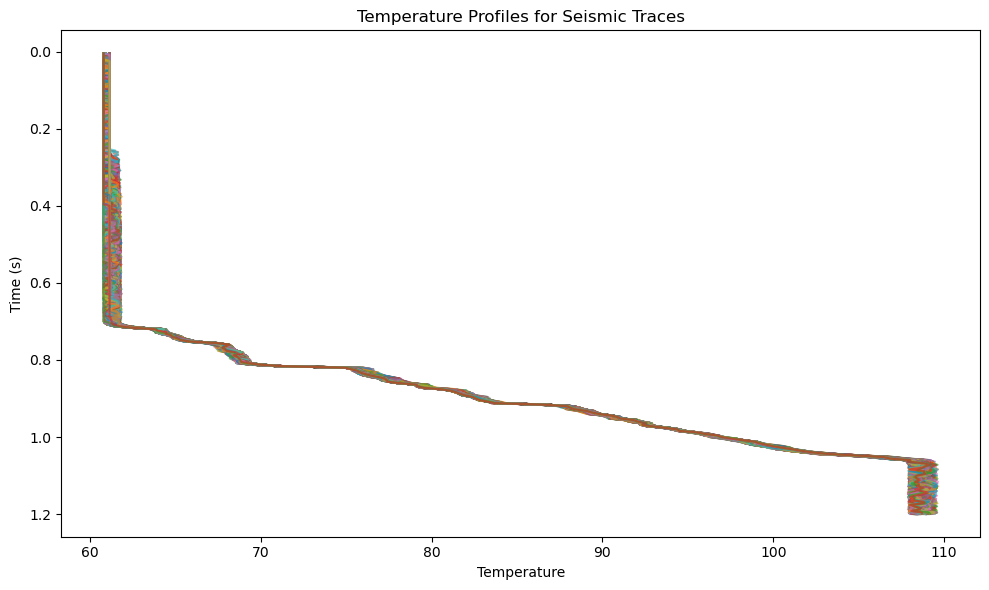

In [10]:
import matplotlib.pyplot as plt

# Get unique trace indices
unique_traces = all_predictions['Trace_Index'].unique()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each trace index
for trace_index in unique_traces:
    # Filter data for the current trace
    trace_data = all_predictions[all_predictions['Trace_Index'] == trace_index]
    
    # Extract time and temperature
    time = trace_data['Time (s)']
    temp = trace_data['TEMP']
    
    # Plot temperature profile for the trace
    plt.plot(temp, time, label=f'Trace {trace_index}', alpha=0.6)

# Add labels, legend, and invert y-axis to mimic seismic style
plt.xlabel('Temperature')
plt.ylabel('Time (s)')
plt.title('Temperature Profiles for Seismic Traces')
plt.gca().invert_yaxis()  # Seismic data style
plt.tight_layout()

# Show the plot
plt.show()
